**Plot the MSE values for the DFM specification with 1 Hard+Surveys factor and lag order 3 using two forecast setups**:

- Hard + Surveys  
- Hard + Surveys + Sign-adjusted Topics (BCC, t+3)

**Evaluation subperiods:** 2008-2018, 2008-2010, and 2011-2018.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


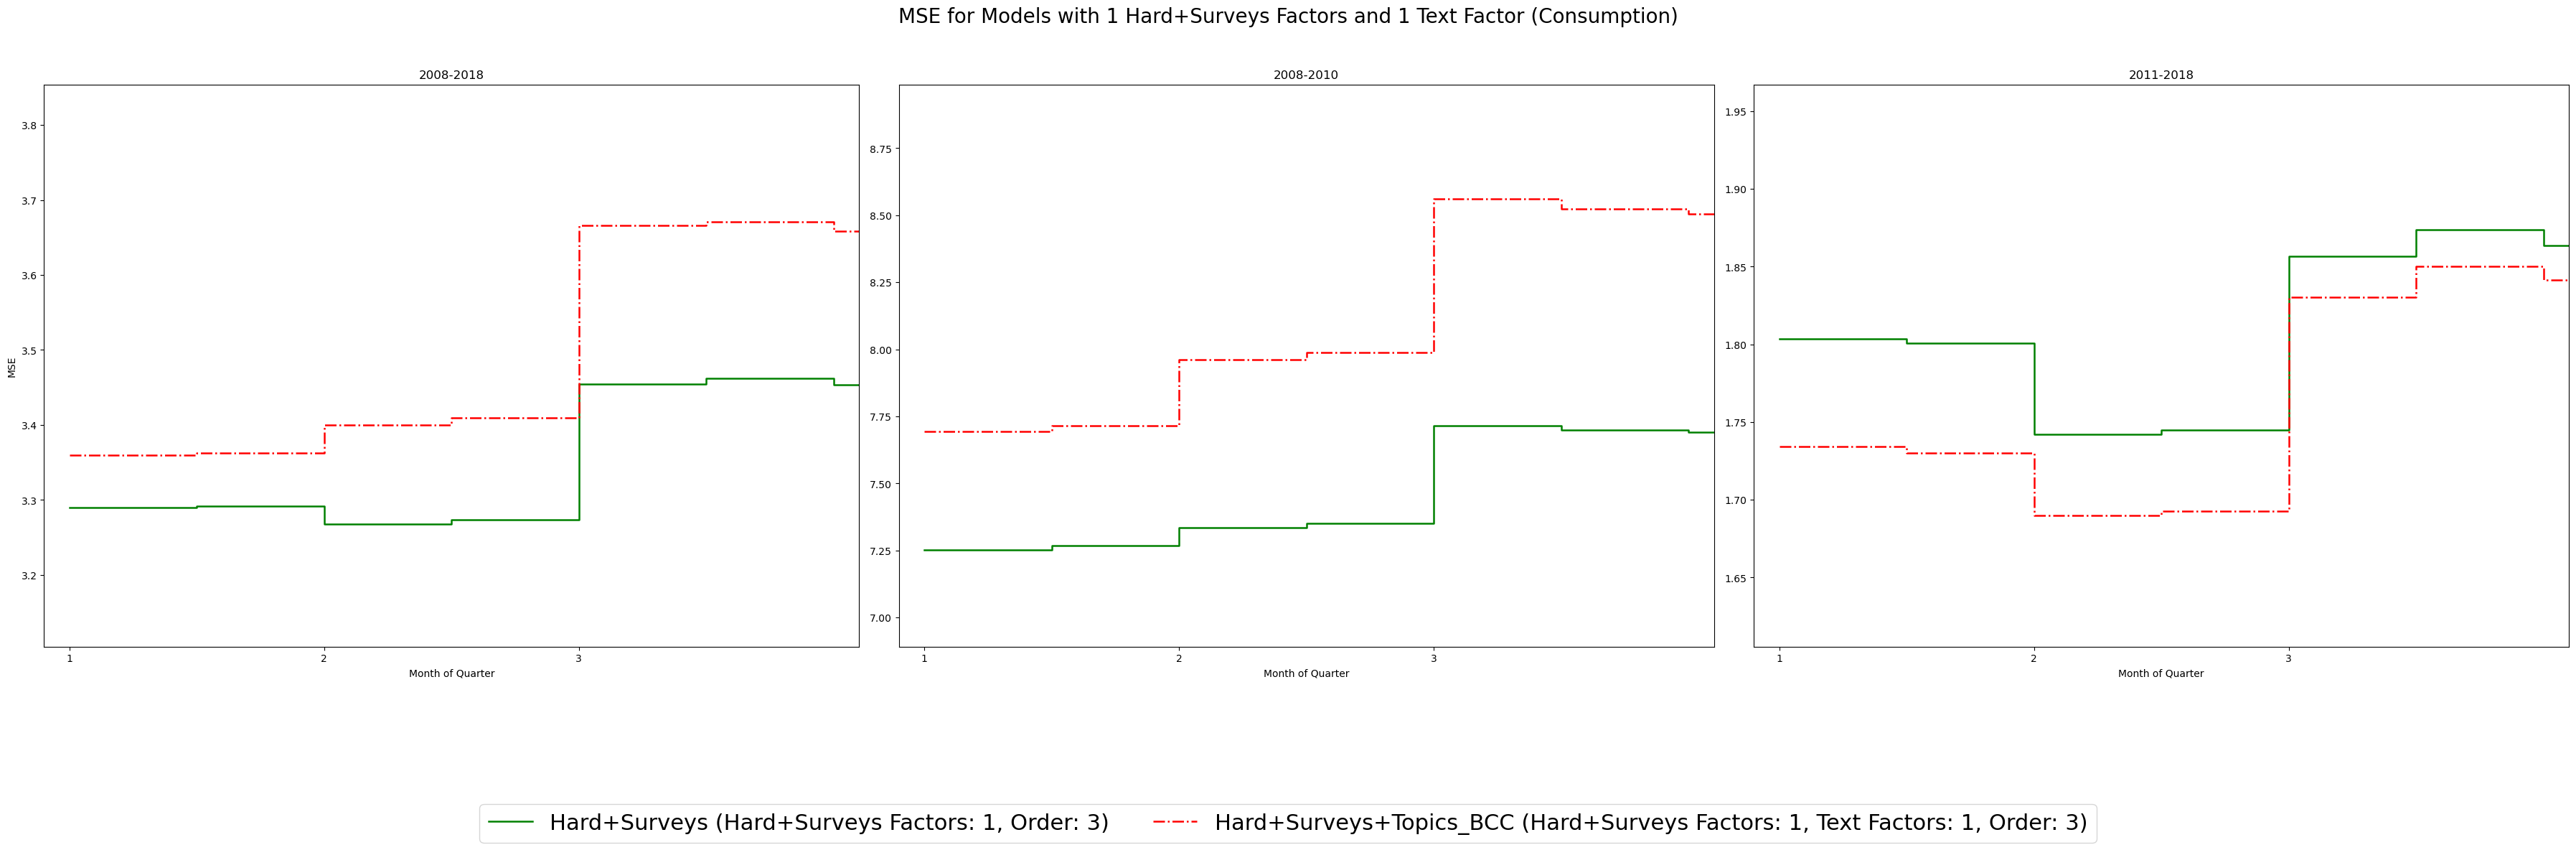

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories for Hard+Surveys and Hard+Surveys+Topics_BCC (t+3)
q_var = 'Consumption'
text_type_bcc = "topics_BCC"
estimation_period_bcc = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir_hard_surveys = f"../../forecasts/DFM_hard_surveys_global_factors_{q_var}"
forecasts_dir_topics_bcc = f"../../forecasts/DFM_{text_type_bcc}_{estimation_period_bcc}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define three periods
periods = {
    "2008-2018": lambda df: df["date_float"] < 2019,
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages and extend to hold the last value
x_values = [x_mapping[col] for col in vintage_col_names]
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# For all models use 1 Hard+Surveys factor and lag order 3:
number_HS = 1
number_HS_bcc = 1
order_hard_surveys = 3
order_topics_bcc = 3

# Create a figure with 1 row and 3 columns (one subplot per period)
fig, axs = plt.subplots(1, 3, figsize=(36, 10))

# Loop over each period and corresponding subplot axis
for ax, (period_label, period_filter) in zip(axs, periods.items()):
    
    # Hard+Surveys model (solid line)
    
    # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
    factors_str_hard_surveys = f"Global_{number_HS}_{order_hard_surveys}"
    forecast_file_name_hard_surveys = f"forecasts_{q_var}_{factors_str_hard_surveys}.csv"
    forecast_file_path_hard_surveys = os.path.join(forecasts_dir_hard_surveys, forecast_file_name_hard_surveys)
    
    # Load forecast data
    forecasts_hard_surveys = pd.read_csv(forecast_file_path_hard_surveys, index_col=0)
    forecasts_hard_surveys.index.name = "date"
    forecasts_hard_surveys.reset_index(inplace=True)
    
    # Merge forecasts with actual growth 
    merged_hard_surveys = pd.merge(forecasts_hard_surveys, actual_growth, on="date", how="inner")
    merged_hard_surveys["date_float"] = merged_hard_surveys["date"].apply(quarter_to_float)
    merged_hard_surveys.sort_values("date_float", inplace=True)
    
    # Filter merged data for the current period
    merged_period_hard_surveys = merged_hard_surveys[ period_filter(merged_hard_surveys) ]
    
    # Calculate MSE for each vintage column over the filtered period
    mse_dict_hard_surveys = {}
    for col in vintage_col_names:
        mse = ((merged_period_hard_surveys[col] - merged_period_hard_surveys["growth"]) ** 2).mean()
        mse_dict_hard_surveys[col] = mse
    
    # Construct y values based on the vintages
    y_values_hard_surveys = [mse_dict_hard_surveys[col] for col in vintage_col_names]
    
    # Extend the y-values so the step function holds the last value
    y_extended_hard_surveys = y_values_hard_surveys.copy()
    y_extended_hard_surveys.append(y_values_hard_surveys[-1]) # Repeat the last value
    
    # Plot the step function for this model
    ax.step(x_extended, y_extended_hard_surveys, where='post', linewidth=1.8, color='green')
    
    # Hard+Surveys+Topics_BCC model (dash-dot line)
    
    # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
    factors_str_topics_bcc = f"HS_{number_HS_bcc}_{order_topics_bcc}"
    forecast_file_name_topics_bcc = f"forecasts_{q_var}_{factors_str_topics_bcc}.csv"
    forecast_file_path_topics_bcc = os.path.join(forecasts_dir_topics_bcc, forecast_file_name_topics_bcc)
    
    # Load forecast data 
    forecasts_topics_bcc = pd.read_csv(forecast_file_path_topics_bcc, index_col=0)
    forecasts_topics_bcc.index.name = "date"
    forecasts_topics_bcc.reset_index(inplace=True)
    
    # Merge forecasts with actual growth dates
    merged_topics_bcc = pd.merge(forecasts_topics_bcc, actual_growth, on="date", how="inner")
    merged_topics_bcc["date_float"] = merged_topics_bcc["date"].apply(quarter_to_float)
    merged_topics_bcc.sort_values("date_float", inplace=True)
    
    # Filter merged data for the current period
    merged_period_topics_bcc = merged_topics_bcc[ period_filter(merged_topics_bcc) ]
    
    # Calculate MSE for each vintage column over the filtered period
    mse_dict_topics_bcc = {}
    for col in vintage_col_names:
        mse = ((merged_period_topics_bcc[col] - merged_period_topics_bcc["growth"]) ** 2).mean()
        mse_dict_topics_bcc[col] = mse
        
    # Construct y values based on the vintages
    y_values_topics_bcc = [mse_dict_topics_bcc[col] for col in vintage_col_names]
    
    # Extend the y-values so the step function holds the last value
    y_extended_topics_bcc = y_values_topics_bcc.copy()
    y_extended_topics_bcc.append(y_values_topics_bcc[-1])
    
    # Plot the step function for this model
    ax.step(x_extended, y_extended_topics_bcc, where='post', linewidth=1.8, linestyle='-.', color='red')
    
    # Customize the subplot for the current period
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{period_label}")
    
    # Set y-axis limits individually based on each subplot's data range
    y_min = min(min(y_extended_hard_surveys), min(y_extended_topics_bcc))
    y_max = max(max(y_extended_hard_surveys), max(y_extended_topics_bcc))
    ax.set_ylim(0.95 * y_min, 1.05 * y_max)
    
    if ax == axs[0]:
        ax.set_ylabel("MSE")
    
# Create a common legend for the entire figure
handles = [
    Line2D([], [], color='green', lw=1.8, label=f"Hard+Surveys (Hard+Surveys Factors: {number_HS}, Order: {order_hard_surveys})"),
    Line2D([], [], color='red', lw=1.8, linestyle='-.', label=f"Hard+Surveys+Topics_BCC (Hard+Surveys Factors: {number_HS_bcc}, Text Factors: 1, Order: {order_topics_bcc})")
]
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=2, prop={'size': 22})

plt.suptitle(f"MSE for Models with {number_HS} Hard+Surveys Factors and 1 Text Factor ({q_var})", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the output directory if it doesn't exist and save the combined figure as PNG and EPS
output_dir = f"DFM_surveys_vs_topics_BCC_lag3_sep_factors_{q_var}"
os.makedirs(output_dir, exist_ok=True)
base_filename = os.path.join(output_dir, f"DFM_surv_vs_topics_BCC_lag3_SF_allPeriods_{q_var}_1F")
plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

plt.show()

Plot the forecasts and actual growth values for the DFM specification with 1 Hard+Surveys factor and lag order 3 across two distinct time periods (2008-2010, and 2011-2018) and using two forecast setups:
- Hard + Surveys  
- Hard + Surveys + Sign-adjusted Topics (BCC, t+3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


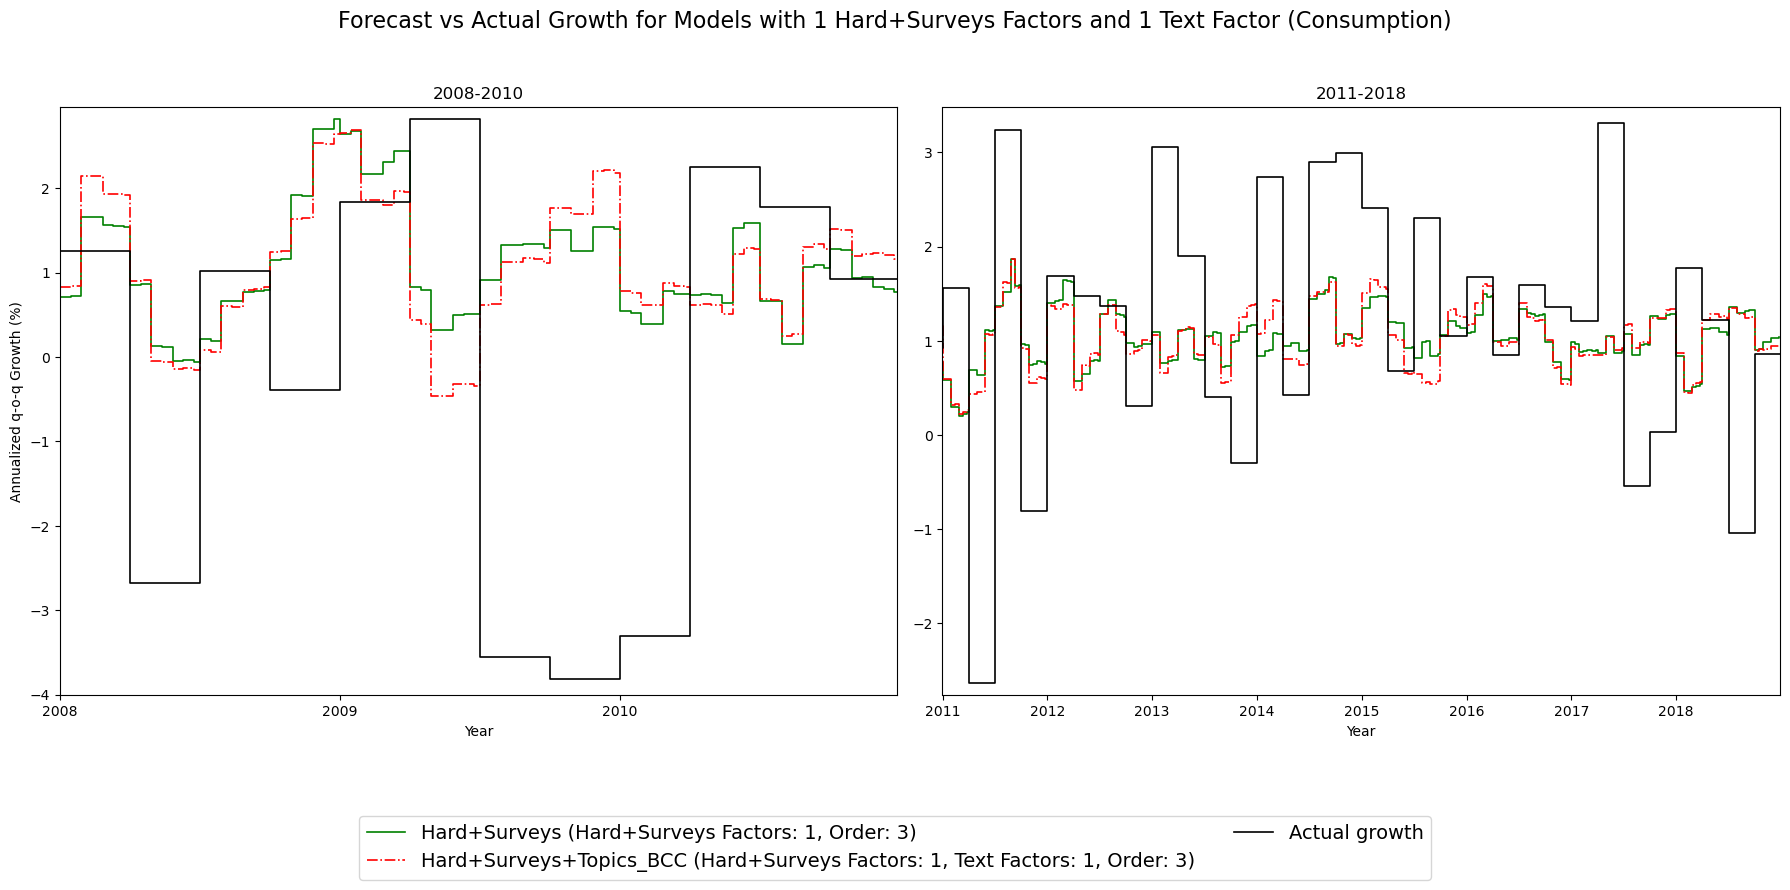

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories for Hard+Surveys and Hard+Surveys+Topics_BCC (t+3)
q_var = 'Consumption'
text_type_bcc = "topics_BCC"
estimation_period_bcc = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"
forecasts_dir_hard_surveys = f"../../forecasts/DFM_hard_surveys_global_factors_{q_var}"
forecasts_dir_topics_bcc = f"../../forecasts/DFM_{text_type_bcc}_{estimation_period_bcc}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations for only two periods (2008-2010 and 2011-2018)
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# For all models use 1 Hard+Surveys factor and lag order 3:
number_HS = 1
number_HS_bcc = 1
order_hard_surveys = 3
order_topics_bcc = 3

# Create a figure with 1 row and 2 columns (one subplot per period)
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Loop over each period configuration to create the subplots
for ax, (period_label, config) in zip(axs, period_configs.items()):
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act
    
    # Hard+Surveys model (solid line)
    
    # Construct forecast file name, e.g., "forecasts_Consumption_Global_1_1.csv"
    factors_str_hard_surveys = f"Global_{number_HS}_{order_hard_surveys}"
    forecast_file_name_hard_surveys = f"forecasts_{q_var}_{factors_str_hard_surveys}.csv"
    forecast_file_path_hard_surveys = os.path.join(forecasts_dir_hard_surveys, forecast_file_name_hard_surveys)
    
    # Load forecast data
    forecasts_hard_surveys = pd.read_csv(forecast_file_path_hard_surveys, index_col=0)
    forecasts_hard_surveys.index.name = "date"
    forecasts_hard_surveys.reset_index(inplace=True)
    
    # Merge forecasts with actual growth dates
    merged_hard_surveys = pd.merge(forecasts_hard_surveys, actual_growth[['date']], on="date", how="inner")
    merged_hard_surveys["date_float"] = merged_hard_surveys["date"].apply(quarter_to_float)
    merged_hard_surveys.sort_values("date_float", inplace=True)
    
    # Build forecast x and y arrays
    x_fore_hard_surveys = []
    y_fore_hard_surveys = []
    for idx, row in merged_hard_surveys.iterrows():
        base_x = row["date_float"]
        # For each of the 7 vintage columns, define an x-position and take that forecast value
        for j, col in enumerate(vintage_col_names):
            x_fore_hard_surveys.append(base_x + offsets[j])
            y_fore_hard_surveys.append(row[col])
    
    # Plot the forecast step curve for this model
    ax.step(x_fore_hard_surveys, y_fore_hard_surveys, where='post', linewidth=1.2, color='green')
    
    # Hard+Surveys+Topics_BCC model (dash-dot line)
    
    # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
    factors_str_topics_bcc = f"HS_{number_HS_bcc}_{order_topics_bcc}"
    forecast_file_name_topics_bcc = f"forecasts_{q_var}_{factors_str_topics_bcc}.csv"
    forecast_file_path_topics_bcc = os.path.join(forecasts_dir_topics_bcc, forecast_file_name_topics_bcc)
    
    # Load forecast data 
    forecasts_topics_bcc = pd.read_csv(forecast_file_path_topics_bcc, index_col=0)
    forecasts_topics_bcc.index.name = "date"
    forecasts_topics_bcc.reset_index(inplace=True)
    
    # Merge forecasts with actual growth dates
    merged_topics_bcc = pd.merge(forecasts_topics_bcc, actual_growth[['date']], on="date", how="inner")
    merged_topics_bcc["date_float"] = merged_topics_bcc["date"].apply(quarter_to_float)
    merged_topics_bcc.sort_values("date_float", inplace=True)
    
    # Build forecast x and y arrays
    x_fore_topics_bcc = []
    y_fore_topics_bcc = []
    for idx, row in merged_topics_bcc.iterrows():
        base_x = row["date_float"]
        # For each of the 7 vintage columns, define an x-position and take that forecast value
        for j, col in enumerate(vintage_col_names):
            x_fore_topics_bcc.append(base_x + offsets[j])
            y_fore_topics_bcc.append(row[col])
            
    # Plot the forecast step curve for this model
    ax.step(x_fore_topics_bcc, y_fore_topics_bcc, where='post', linewidth=1.2, linestyle='-.', color='red')
    
    # Plot actual growth as a step plot
    ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2)
    
    # Customize each subplot
    ax.set_xlabel("Year")
    ax.set_xlim(config["xlim"][0], config["xlim"][1])
    ax.set_xticks(config["xticks"])
    ax.set_title(f"{period_label}")
    
    # Set y-axis limits based on the data within the period range
    x_min, x_max = config["xlim"]
    def filter_points(x_arr, y_arr, x_min, x_max):
        return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]
    
    # Filter y-values
    y_hard_surveys_filtered = filter_points(x_fore_hard_surveys, y_fore_hard_surveys, x_min, x_max)
    y_topics_bcc_filtered = filter_points(x_fore_topics_bcc, y_fore_topics_bcc, x_min, x_max)
    y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
    
    # Combine all filtered y-values
    combined_y = y_hard_surveys_filtered + y_topics_bcc_filtered + y_act_filtered
    ax.set_ylim(1.05 * min(combined_y), 1.05 * max(combined_y))
    
    if ax == axs[0]:
        ax.set_ylabel("Annualized q-o-q Growth (%)")

# Create a common legend for the entire figure
handles = [
    Line2D([], [], color='green', lw=1.2, label=f"Hard+Surveys (Hard+Surveys Factors: {number_HS}, Order: {order_hard_surveys})"),    
    Line2D([], [], color='red', lw=1.2, linestyle='-.', label=f"Hard+Surveys+Topics_BCC (Hard+Surveys Factors: {number_HS_bcc}, Text Factors: 1, Order: {order_topics_bcc})"),
    Line2D([], [], color='black', lw=1.2, label="Actual growth")   
]
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.12), ncol=2, prop={'size': 14})

plt.suptitle(f"Forecast vs Actual Growth for Models with {number_HS} Hard+Surveys Factors and 1 Text Factor ({q_var})", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

# Create the output directory if it doesn't exist and save the combined figure as PNG and EPS
output_dir = f"DFM_surveys_vs_topics_BCC_lag3_sep_factors_{q_var}"
os.makedirs(output_dir, exist_ok=True)
base_filename = os.path.join(output_dir, f"DFM_surv_vs_topics_BCC_lag3_SF_FVA_allPeriods_{q_var}_1F")
plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")
plt.show()

## Diebold-Mariano

Finally, I use a one-sided Diebold-Mariano test to determine whether a model combining Hard+Surveys data with Topics_BCC most highly correlated with Consumption at t+3 achieves statistically significantly lower mean squared error than the Hard+Surveys benchmark.

In [3]:
import numpy as np
from scipy.stats import norm

# Newey–West variance estimator (lag q)
def newey_west_var(d, q=0):
    """
    Returns Newey–West estimate of Var(d) with truncation lag q.
    If q=0, reduces to the sample variance.
    """
    d = np.asarray(d)
    n = len(d)
    gamma0 = np.var(d, ddof=1)
    if q == 0:
        return gamma0
    s = gamma0
    for k in range(1, q+1):
        gamma_k = np.cov(d[k:], d[:-k], ddof=1)[0,1]
        s += 2 * (1 - k/(q+1)) * gamma_k
    return s

# Diebold–Mariano test
def dm_test(e_combo, e_hs, lag=0, one_sided=False):
    """
    e_combo, e_hs: 1‐d arrays of forecast errors (forecast – actual)
    lag: truncation lag for Newey–West 
    one_sided: if True, test H1 = combo better (lower MSE); else two‐sided
    Returns DM_statistic, p_value
    """
    d = e_combo**2 - e_hs**2
    T = len(d)
    d_bar = d.mean()
    var_d = newey_west_var(d, lag)
    DM = d_bar / np.sqrt(var_d / T)
    if one_sided:
        # H1: combination has LOWER MSE => DM < 0 
        p = norm.cdf(DM)
    else:
        p = 2 * (1 - norm.cdf(abs(DM)))
    return DM, p

def fmt_cell(ratio, p):
    s = f"{ratio:.2f}"
    # Add stars for the DM‐test
    if p <= 0.01:
        s += "***"
    elif p <= 0.05:
        s += "**"
    elif p <= 0.10:
        s += "*"
    # Bold if the rounded ratio is ≤ 0.95
    if round(ratio, 2) <= 0.95:
        s = "\\textbf{" + s + "}"
    return s

In [4]:
import os
import pandas as pd

vints = ["M1-01","M1-16","M2-01","M2-16","M3-01","M3-16","M4-01"]

# Forecast variable and directories for Hard+Surveys and Hard+Surveys+Topics_BCC (t+3)
q_var = 'Consumption'
text_type_bcc = "topics_BCC"
estimation_period_bcc = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"

forecasts_dir_hs          = f"../../forecasts/DFM_hard_surveys_global_factors_{q_var}"
forecasts_dirs_combos     = [
    f"../../forecasts/DFM_{text_type_bcc}_{estimation_period_bcc}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
]
combo_labels = ["Topics\\_BCC"]

# Load actuals
actuals = pd.read_csv(f"../../{q_var}_growth_actual.csv")

# Header, rename last column for LaTeX
header = vints[:-1] + ["M1-01 (Q(t+1))"]
latex_header = " & ".join(header) + " \\\\ \\midrule\n"

# Use 1 global factor for Hard+Surveys model
number_global = 1

rows = []
for dir_combo in forecasts_dirs_combos:
    # Read in the two forecasts
    hs_df    = pd.read_csv(f"{forecasts_dir_hs}/forecasts_{q_var}_Global_{number_global}_3.csv", index_col=0)
    combo_df = pd.read_csv(f"{dir_combo}/forecasts_{q_var}_HS_{number_global}_3.csv", index_col=0)
    # Merge on date and add actuals
    merged = (hs_df.reset_index().rename(columns={'index':'date'})
              .merge(combo_df.reset_index().rename(columns={'index':'date'}), on='date',
                     suffixes=('_hs','_combo'))
              .merge(actuals, on='date'))
    # Compute RMSE ratios and p-values
    cells = []
    for vint in vints:
        e_hs    = merged[f"{vint}_hs"]    - merged["growth"]
        e_combo = merged[f"{vint}_combo"] - merged["growth"]
        rmse_hs    = np.sqrt((e_hs**2).mean())
        rmse_combo = np.sqrt((e_combo**2).mean())
        ratio      = rmse_combo / rmse_hs
        _, pval    = dm_test(e_combo, e_hs, lag=1, one_sided=True)
        cells.append(fmt_cell(ratio, pval))
    rows.append(" & ".join(cells) + " \\\\")
    
# The Latex table
latex = (
    "\\begin{tabular}{l" + "c"*7 + "}\n"
    "\\toprule\n"
    "Combination & " + " & ".join(header) + " \\\\\n"
    "\\midrule\n"
)
for label, row in zip(combo_labels, rows):
    latex += f"{label} & {row}\n"
latex += "\\bottomrule\n\\end{tabular}\n"

# Create the output directory if it doesn't exist and save the table
output_dir = f"DM//DFM_surveys_vs_topics_BCC_lag3_sep_factors_{q_var}"
os.makedirs(output_dir, exist_ok=True)
base_filename = os.path.join(output_dir, f"DFM_surv_vs_topics_BCC_lag3_SF_DM_allPeriods_{q_var}_1F")

with open(base_filename + ".tex", "w") as f:
    f.write(latex)

And now I test MSE difference for subperiods: 2008-2010 and 2011-2018.

In [5]:
vints = ["M1-01","M1-16","M2-01","M2-16","M3-01","M3-16","M4-01"]

# Forecast variable and directories for Hard+Surveys and Hard+Surveys+Topics_BCC (t+3)
q_var = 'Consumption'
text_type_bcc = "topics_BCC"
estimation_period_bcc = "2009"
num_topics = "200"
source = "all"
selected = "_lag3"

forecasts_dir_hs          = f"../../forecasts/DFM_hard_surveys_global_factors_{q_var}"
forecasts_dirs_combos     = [
    f"../../forecasts/DFM_{text_type_bcc}_{estimation_period_bcc}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
]
combo_labels = ["Topics\\_BCC"]

# Load actuals and parse dates
actuals = pd.read_csv(f"../../{q_var}_growth_actual.csv")
actuals['date'] = pd.to_datetime(actuals['date'])

# Header, rename last column for LaTeX
header = vints[:-1] + ["M1-01 (Q(t+1))"]
latex_header = " & ".join(header) + " \\\\ \\midrule\n"

# Use 1 global factor for Hard+Surveys model
number_global = 1

# Define sub‐periods
periods = {
    "2008_2010": ("2008-01-01", "2010-12-31"),
    "2011_2018": ("2011-01-01", "2018-12-31"),
}

for period_name, (start, end) in periods.items():
    rows = []
    for dir_combo in forecasts_dirs_combos:
        # Read in the two forecasts
        hs_df    = pd.read_csv(f"{forecasts_dir_hs}/forecasts_{q_var}_Global_{number_global}_3.csv", index_col=0)
        hs_df    = hs_df.reset_index().rename(columns={'index':'date'})
        hs_df['date'] = pd.to_datetime(hs_df['date'])
        
        combo_df = pd.read_csv(f"{dir_combo}/forecasts_{q_var}_HS_{number_global}_3.csv", index_col=0)
        combo_df = combo_df.reset_index().rename(columns={'index':'date'})
        combo_df['date'] = pd.to_datetime(combo_df['date'])

        # Merge on date and add actuals
        merged = (hs_df.merge(combo_df, on='date', suffixes=('_hs','_combo'))
              .merge(actuals, on='date'))
        merged['date'] = pd.to_datetime(merged['date'])

        # Slice to sub‐period
        sub = merged[(merged['date'] >= start) & (merged['date'] <= end)]

        # Compute RMSE ratios and p‐values
        cells = []
        for vint in vints:
            e_hs    = sub[f"{vint}_hs"]    - sub["growth"]
            e_combo = sub[f"{vint}_combo"] - sub["growth"]
            rmse_hs    = np.sqrt((e_hs**2).mean())
            rmse_combo = np.sqrt((e_combo**2).mean())
            ratio      = rmse_combo / rmse_hs
            _, pval    = dm_test(e_combo, e_hs, lag=1, one_sided=True)
            cells.append(fmt_cell(ratio, pval))
        rows.append(" & ".join(cells) + " \\\\")

    # Assemble full LaTeX table
    latex = (
        "\\begin{tabular}{l" + "c"*7 + "}\n"
        "\\toprule\n"
        "Combination & " + " & ".join(header) + " \\\\\n"
        "\\midrule\n"
    )
    for label, row in zip(combo_labels, rows):
        latex += f"{label} & {row}\n"
    latex += "\\bottomrule\n\\end{tabular}\n"
 
    # Create the output directory if it doesn't exist and save the table
    output_dir = f"DM//DFM_surveys_vs_topics_BCC_lag3_sep_factors_{q_var}"
    os.makedirs(output_dir, exist_ok=True)
    base_filename = os.path.join(output_dir, f"DFM_surv_vs_topics_BCC_lag3_SF_DM_{period_name}_{q_var}_1F")

    with open(base_filename + ".tex", "w") as f:
        f.write(latex)